# Feedback Linearization

Feedback-linearization, also known as nonlinear dynamic-inversion, is a control method where non-linear dynamics are transformed into linear dynamics through a change of variables and a suitable choice of control input. [Wikipedia](https://en.wikipedia.org/wiki/Feedback_linearization)

## Original Dynamics

Consider the dynamics of the turtle sim in ROS:

$\dot{p_x} = s \cos{\theta}$

$\dot{p_y} = s \sin{\theta}$

$\dot{\theta} = \omega$

We can express the dynamics in state space form as:

$\vec{x} = \begin{bmatrix}p_x & p_y & \theta\end{bmatrix}^T$

$\vec{u} = \begin{bmatrix}s & \omega\end{bmatrix}^T$

$\dot{\vec{x}} = f(\vec{x},  \vec{u}) = \begin{bmatrix}s \cos{\theta} & s \sin{\theta} & \omega\end{bmatrix}^T$

## Inverted Dynamics

We claim that the system is **differentially flat** in the variables $x$, $y$. To show this, we must express all other variables, $\theta$, $s$, and $\omega$ in terms of $p_x$, $p_y$, and their derivatives. [Wikipedia](https://en.wikipedia.org/wiki/Flatness_(systems_theory))

$\theta = \arctan{\dfrac{\dot{p_y}}{\dot{p_x}}}$

$s = \sqrt{\dot{p_x}^2 + \dot{p_y}^2}$

$\omega = \dot{\theta} = \dfrac{\dot{p_x} \ddot{p_y} - \dot{p_y}\ddot{p_x}}{\dot{p_x}^2 + \dot{p_y}^2}$

$\therefore$ the system is differentially flat.

## Controller Derviation

Define $\vec{p} \equiv \begin{bmatrix} p_x & p_y \end{bmatrix}^T$ 

Define $\vec{r} \equiv \begin{bmatrix} r_x & r_y \end{bmatrix}^T$ 

Define $\vec{e} \equiv \vec{r} - \vec{p}$ 

We wish to have the error dynamics:

$\ddot{\vec{e}} + 2 \zeta \omega_n \dot{\vec{e}} + \omega_n^2 \vec{e} = 0$

Which after substitution can be solved for the desired acceleration, $\ddot{\vec{p}}$:

$\left(\ddot{\vec{r}} - \ddot{\vec{p}}\right) + 2 \zeta \omega_n \left(\dot{\vec{r}} - \dot{\vec{p}}\right) + \omega_n^2 \left(\vec{r} - \vec{p}\right) = 0$

$\ddot{\vec{p}} = \ddot{\vec{r}} + 2 \zeta \omega_n \left(\dot{\vec{r}} - \dot{\vec{p}}\right) + \omega_n^2 \left(\vec{r} - \vec{p}\right)$

Finally, our control inputs to achieve these accelerations are $s$ and $\omega$, which depend on $a_x$ and $a_y$:

$\dot{s} = a_x \cos{\theta} + a_y \sin{\theta}$

$\omega = \dfrac{-a_x \sin{\theta} + a_y \cos{\theta}}{s}$

Note that we $a_x$ and $a_y$ determine the derivative of $s$, so $s$ is a state of the controller that must be integrated.

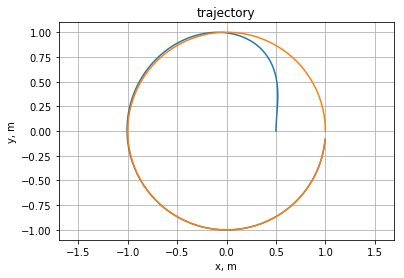

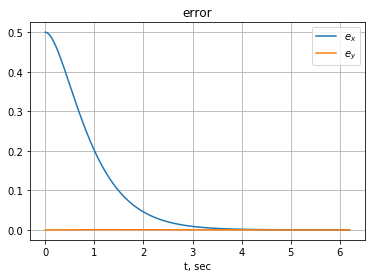

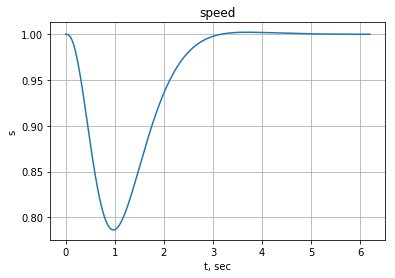

In [4]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
%matplotlib inline

def simulate(controller, reference_trajectory, dynamics, x0, tf=6.2, dt=0.01):
    """
    @param Controller: The controller for the vehicle
    @param reference_trajectory: The trajectory to follow
    @param dynamics: The dynamics of the vehicle
    @param x0: The initial state
    @param tf: The final time
    @param dt: The time step for the controller.
    """
    assert len(x0) == 3
    data = {
        't': [],
        'x': [],
        'rp': [],
        'rv': [],
        'ra': [],
        's': [],
        'omega': []
    }

    t = 0
    x = x0
    u = np.array([0, 0])
    while t < tf:
        # control
        rp, rv, ra = reference_trajectory(t)
        u = controller.update(x, rp, rv, ra, t, dt)
        
        # store data
        s, omega = u
        data['t'].append(t)
        data['x'].append(x)
        data['rp'].append(rp)
        data['rv'].append(rv)
        data['ra'].append(ra)
        data['s'].append(s)
        data['omega'].append(omega)

        # integrate
        t += dt
        res = scipy.integrate.solve_ivp(
            fun=lambda t, x: dynamics(t, x, u),
            t_span=[t, t + dt], t_eval=[t + dt], y0=x)
        x = res['y'][:, 0]

    for key in data.keys():
        data[key] = np.array(data[key])

    return data

class TurtleController:
    """
    This class is the controller for the turtle. It uses dynamic inversion of feedback linearization.
    """
    
    def __init__(self, zeta=0.707, wn=3, s0=1):
        self.s = s0
        self.zeta = zeta
        self.wn = wn
        
    def update(self, x, rp, rv, ra, t, dt):
        s = self.s
        zeta = self.zeta
        wn = self.wn
        px, py, theta = x
        p = np.array([px, py])
        v = np.array([s*np.cos(theta), s*np.sin(theta)])
        a = ra + 2*zeta*wn*(rv - v) + wn**2*(rp - p)
        ds = a[0]*np.cos(theta) + a[1]*np.sin(theta)
        if np.abs(s) < 1e-3:
            omega = 0
        else:
            omega = (-a[0]*np.sin(theta) + a[1]*np.cos(theta))/s
        self.s += ds*dt
        return [self.s, omega]

def turtle_dynamics(t, x, u):
    """
    The dynamics of the turtle
    """
    px, py, theta = x
    s, omega = u
    
    # input saturation
    s = np.min([np.max([0, s]), 2])
    omega = np.min([np.max([-10, omega]), 10])

    dx = [s*np.cos(theta), s*np.sin(theta), omega]
    return dx

def circle_trajectory(t):
    """
    A circular reference trajectory:
    @return rp, rv, ra: where rp is position [px, py], rv is velocity [rvx, rvy], ra is accel [rax, ray]
    """
    rp = [np.cos(t), np.sin(t)]
    rv = [-np.sin(t), np.cos(t)]
    ra = [-np.cos(t), -np.sin(t)]
    return rp, rv, ra

def plotting(data):
    """
    plotting for simulation
    """
    plt.figure()
    plt.plot(data['x'][:, 0], data['x'][:, 1]);
    plt.plot(data['rp'][:, 0], data['rp'][:, 1])
    plt.axis('equal')
    plt.xlabel('x, m')
    plt.ylabel('y, m')
    plt.title('trajectory')
    plt.grid()

    plt.figure()
    plt.title('error')
    plt.xlabel('t, sec')
    plt.plot(data['t'], data['rp'][:, 0] - data['x'][:, 0], label='$e_x$')
    plt.plot(data['t'], data['rp'][:, 1] - data['x'][:, 1], label='$e_y$')
    plt.grid()
    plt.legend()

    plt.figure()
    plt.title('speed')
    plt.xlabel('t, sec')
    plt.ylabel('s')
    plt.plot(data['t'], data['s'])
    plt.grid()
    
data = simulate(
    controller=TurtleController(zeta=1, wn=2),
    reference_trajectory=circle_trajectory,
    dynamics=turtle_dynamics, x0=[0.5, 0, np.deg2rad(90)])
plotting(data)